# Import statements

In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

from sklearn.model_selection import train_test_split

from sklearn.pipeline import  Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve


#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

# Define utility functions

In [2]:
def simple_clean(doc, regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")] ):
    
    # Make sure it is a string!
    doc = str(doc)
    
    # remove or replace characters
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    # lowercase
    doc = doc.lower()
    # Trim
    doc = doc.strip()
    # tokenize
    #words = tokenizer.tokenize(doc)
    # remove punctuation
    #words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    #stems = list(map(stemmer.stem, words))
    #new_doc = " ".join(stems)
    new_doc = doc
    return new_doc

# Load original data

In [3]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')


# Train-Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ContrabandIndicator'), 
                                                    df['ContrabandIndicator'], 
                                                    test_size=0.6, 
                                                    random_state=42)

# Pre-process 

Both the train set and the test set will enter this pre-processing to prepare for fits ans transforms:
* Select columns to keep;
* Clean text features;

In [237]:
def pre_process_data(df: pd.DataFrame) -> pd.DataFrame:
    
    """Transforms the original DataFrame to make it suited to enter the workflow.
    
    Args:
        df (pd.DataFrame):  Original DataFrame, it will be first X_train and then X_test.
        
    Returns:
        df_new (pd.DataFrame): Transformed DataFrame, ready to enter the workflow.
        
    TODO:
        * to do list
        
    """
    
    columns_to_keep = ['Department Name', 'SearchAuthorizationCode', 'StatuteReason', 'SubjectAge']
    
    #columns_to_keep = ['Department Name', 'SearchAuthorizationCode','StatuteReason', 'SubjectAge', 'ResidentIndicator']

    #     columns_to_keep = ['Department Name', 
#                        'InterventionReasonCode',
#                        'ResidentIndicator', 
#                        'SearchAuthorizationCode', 
#                        'StatuteReason', 
#                        'SubjectAge', 
#                        'SubjectEthnicityCode', 
#                        'SubjectRaceCode', 
#                        'SubjectSexCode'
#                        ]
    
    # copy the argument
    df_new = df.copy()
    
    df_new = df_new[columns_to_keep]
    
    # Clean text features
    df_new['Department Name'] = df_new['Department Name'].apply(simple_clean)
    df_new['SearchAuthorizationCode'] = df_new['SearchAuthorizationCode'].apply(simple_clean)
    df_new['StatuteReason'] = df_new['StatuteReason'].apply(simple_clean)
    
    
    return df_new

# Code workflow

In [238]:
# Initializations

decision_thr = 0.5

ordinalencoder = ce.ordinal.OrdinalEncoder()
binarizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
clf = RandomForestClassifier(random_state = 42)


X_train_cln = pre_process_data(X_train)
X_train_cln = ordinalencoder.fit_transform(X_train_cln)
X_train_cln['SubjectAge'] = binarizer.fit_transform(X_train_cln[['SubjectAge']])
clf.fit(X_train_cln, y_train)


X_test_cln = pre_process_data(X_test)
X_test_cln = ordinalencoder.fit_transform(X_test_cln)
X_test_cln['SubjectAge'] = binarizer.fit_transform(X_test_cln[['SubjectAge']])

#y_pred = clf.predict(X_test_cln)
y_prob = clf.predict_proba(X_test_cln)[:,1]
y_pred = y_prob > decision_thr


C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Pipeline workflow

In [239]:
# Custom transformer to implement sentence cleaning
class TextCleanerTransformer(TransformerMixin):
    def __init__(self, 
                 regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")], 
                 lower=True, 
                 remove_punct=True):
        self.regex_list = regex_list
        self.lower = lower
        self.remove_punct = remove_punct
        
    def transform(self, X, *_):
        #X = list(map(self._clean_sentence, X.values))
        X_copy = X.copy()
        X_copy = X_copy.applymap(self._clean_sentence)
        return X_copy
    
    def _clean_sentence(self, sentence):
        
        # Make sure it is a string!
        sentence = str(sentence)
        
        # Replace given regexes
        for regex in self.regex_list:
            sentence = re.sub(regex[0], regex[1], sentence)
            
        # lowercase
        if self.lower:
            sentence = sentence.lower()
        
        # Trim
        sentence = sentence.strip()
        
        return sentence
    
    def fit(self, *_):
        return self

In [240]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

    
class BoolSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[self.key]

In [241]:
text_pipe = Pipeline([
                ('selector', TextSelector(['Department Name', 'SearchAuthorizationCode', 'StatuteReason'])),
                ('cleaner', TextCleanerTransformer()),
                ('ordinalencoder', ce.ordinal.OrdinalEncoder())
            ])

numerical_pipe =  Pipeline([
                ('selector', NumberSelector(['SubjectAge'])),
                ('binarizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'))
            ])

bool_pipe =  Pipeline([
                ('selector', BoolSelector(['ResidentIndicator']))                
            ])

# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text_pipe), 
                      ('numerical', numerical_pipe)])

#feats = FeatureUnion([('text', text_pipe)])

# feats = FeatureUnion([('text', text_pipe), 
#                       ('numerical', numerical_pipe),
#                       ('bool', bool_pipe)])

pipe_clf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [242]:
pipe_clf.fit(X_train, y_train)

y_prob_pipe = pipe_clf.predict_proba(X_test)[:,1]
y_pred_pipe = y_prob_pipe > decision_thr

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Validate pipeline results

In [243]:
np.absolute(y_prob - y_prob_pipe).sum()

0.0

In [244]:
(y_pred != y_pred_pipe).sum()

0

# Metrics

In [245]:
precision_score(y_test, y_pred)

0.5821693907875186

In [246]:
recall_score(y_test, y_pred)

0.5094266025224288

In [247]:
accuracy_score(y_test, y_pred)

0.7139816705034097

In [248]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.82      0.79     30664
        True       0.58      0.51      0.54     15382

   micro avg       0.71      0.71      0.71     46046
   macro avg       0.68      0.66      0.67     46046
weighted avg       0.71      0.71      0.71     46046



# Curves

In [17]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
AUROC = roc_auc_score(y_test, y_prob)*100

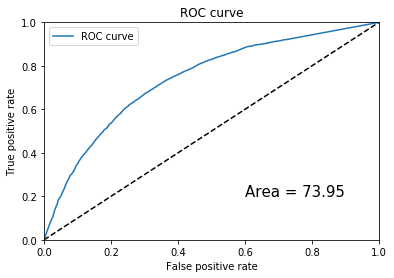

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

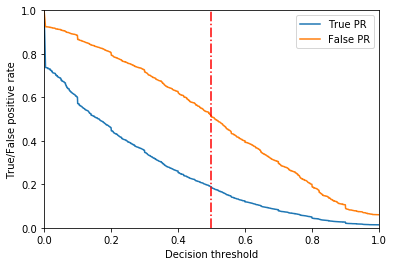

In [19]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='True PR')
plt.plot(thresholds_roc, tpr, label='False PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [20]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

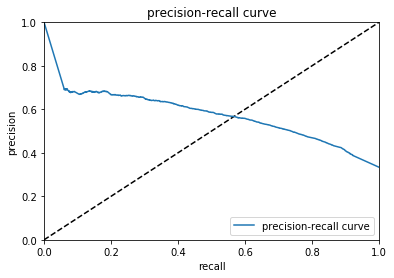

In [21]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall, precision, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

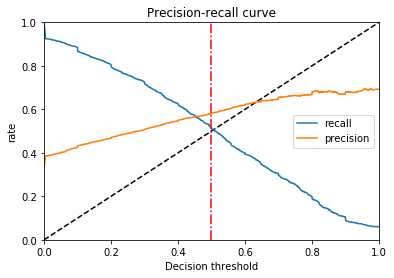

In [22]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_pr, recall[:-1] , label='recall')
plt.plot(thresholds_pr, precision[:-1], label='precision')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('rate')
plt.title('Precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [23]:
df_results = y_test.to_frame(name='y_true')
df_results['y_pred'] = y_pred
df_results['y_prob'] = y_prob
df_results.head()

,y_true,y_pred,y_prob
30717,False,False,0.433333
44889,True,True,0.828644
13938,False,False,0.206627
20220,False,False,0.265000
21837,True,True,0.900000


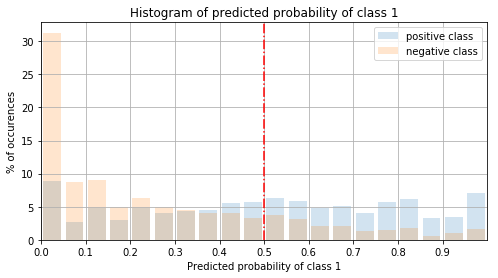

In [24]:
n_trues = df_results[df_results.y_true==True].shape[0]
n_falses = df_results[df_results.y_true==False].shape[0]

plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, weights=np.ones(n_trues)/n_trues*100, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, weights=np.ones(n_falses)/n_falses*100, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

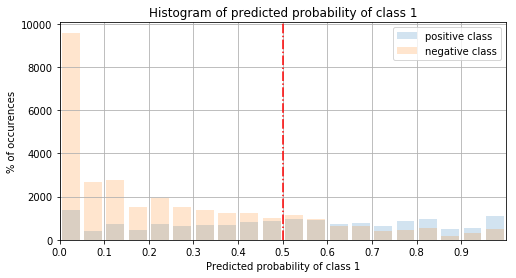

In [25]:
plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

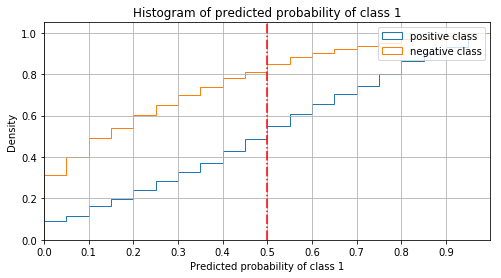

In [26]:
df_results[df_results.y_true==True].y_prob.hist(bins=20, figsize=(8,4), histtype='step',label='positive class', density=True, cumulative=True)
df_results[df_results.y_true==False].y_prob.hist(bins=20, figsize=(8,4), histtype='step', label='negative class', density=True, cumulative=True)

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Density")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [27]:
df_results.set_index('y_prob').y_true

y_prob
0.433333    False
0.828644     True
0.206627    False
0.265000    False
0.900000     True
0.100000    False
0.000000    False
0.079487    False
0.439607    False
0.855184     True
0.000000    False
0.000000    False
0.450601     True
0.000000    False
0.330000     True
0.091883    False
0.231133    False
0.103737    False
0.000000    False
0.848868     True
0.476807     True
0.000000    False
0.600000    False
0.490833     True
0.300000    False
0.104556    False
0.468018    False
0.581667    False
0.754279     True
0.122584    False
            ...  
0.789874     True
0.000000    False
0.000000    False
0.000000    False
0.434865     True
0.358333    False
0.000000     True
0.333333    False
0.259444     True
0.245087    False
0.300000     True
0.678333     True
0.861492     True
0.476071    False
0.900000    False
0.033333     True
0.910193     True
0.023360    False
0.004545    False
0.076869    False
0.000000    False
0.000000    False
0.000000    False
0.458370     True
0.7

### Predict all `True`

In [28]:
y_pred_true = np.ones(y_test.shape).astype(bool)

In [29]:
precision_score(y_test, y_pred_true)

0.3340572471007254

In [30]:
recall_score(y_test, y_pred_true)

1.0

In [31]:
accuracy_score(y_test, y_pred_true)

0.3340572471007254

### Predict all `False`

In [32]:
y_pred_false = np.zeros(y_test.shape).astype(bool)

In [33]:
precision_score(y_test, y_pred_false)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [34]:
recall_score(y_test, y_pred_false)

0.0

In [35]:
accuracy_score(y_test, y_pred_false)

0.6659427528992746

### Predict randomly with positive\negative ratio `r`

In [36]:
np.random.seed(425)
ratio = 0.90

In [37]:
# y_pred_rand = np.random.randint(2, size=y_test.shape).astype(bool)
y_pred_rand = np.random.binomial(n=1, p=ratio, size=y_test.shape).astype(bool)

In [38]:
y_pred_rand.sum()/y_pred_rand.shape[0]

0.9005342483603354

In [39]:
y_pred_rand.shape

(46046,)

In [40]:
precision_score(y_test, y_pred_rand)

0.3345150243573048

In [41]:
recall_score(y_test, y_pred_rand)

0.9017683006111039

In [42]:
accuracy_score(y_test, y_pred_rand)

0.36789297658862874